In [114]:
import tensorflow as tf
from tensorflow.python.keras.layers import Input, Dense, preprocessing, Conv2D, MaxPooling2D, Activation, Dropout, Flatten, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.backend import backend as K
from tensorflow.python.keras.backend import eval
from tensorflow.python.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.callbacks import TensorBoard
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Plot training data

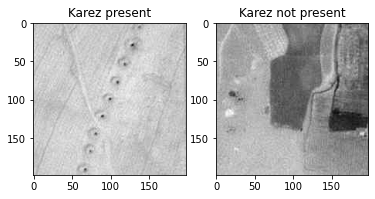

(198, 198)


In [115]:
#--- plot a training image 
import os
import matplotlib.image as img
import matplotlib.pyplot as plt

dirPath = 'C:/sarah/kfold/buffer100_scale/'

fname = os.path.join(dirPath, 'train/karez/shaft_006.jpg')

image = img.imread(fname)
plt.subplot(1,2,1)
plt.imshow(image, cmap ='gray')
plt.title('Karez present')


fname = os.path.join(dirPath, 'train/nokarez/shaft_006.jpg')
image = img.imread(fname)
plt.subplot(1,2,2)
plt.imshow(image, cmap ='gray')
plt.title('Karez not present')
plt.show()

print(image.shape)

Set up default hyperparameters and constants

In [116]:
batch_size              = 32         
num_of_valid_samples    = 720
num_of_train_samples    = 2960
imx                     = image.shape[0]
imy                     = image.shape[1]
epoch                   = 100

#--- hyperparameters that are unused in this notebook 
l2_param                = 0.1    # L2 regularisation to prevent overfit 0-0.1 
momentum_param          = 0.9    # default 0.99 reducing it to dampen oscillations
lr_param                = 0.0001 # learning rate default 0.001 

Set up the network topology. The Adam optimiser uses an adaptive learning rate 
so no need to use the LearningRateScheduler 

In [117]:
model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape=(imx, imy, 1),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
          
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['accuracy'])


Augment the training data and rescale 0-1

In [118]:
train_datagen = ImageDataGenerator(
                rotation_range=180,
                width_shift_range=0.1,
                height_shift_range=0.1,
                rescale=1./255,
                shear_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True,
                fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        dirPath + '/train',
        target_size=(imx, imy),
        batch_size=batch_size,
        color_mode='grayscale',
        shuffle=True,
        seed=42,
        class_mode='binary')

Found 2960 images belonging to 2 classes.


Validation data. Using an 80% (train) and 20% (validate) split. 
No need to augment the validation data, just rescale it. 

In [119]:
valid_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = valid_datagen.flow_from_directory(
        dirPath + '/valid/',
        target_size=(imx, imy),
        batch_size=batch_size,
        color_mode='grayscale',
        shuffle=False,
        seed=42,
        class_mode='binary')


Found 740 images belonging to 2 classes.


Set up a call back to stop early if the validation loss has stopped decreasing

In [120]:
tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


Train the model

In [121]:
history = model.fit(
        train_generator,
        epochs=epoch,
        shuffle=True,
        callbacks=[callback], 
        verbose=1,
        steps_per_epoch=num_of_train_samples//batch_size,
        validation_data=validation_generator)


Epoch 1/100
92/92 [==============================] - 29s 320ms/step - loss: 0.7988 - accuracy: 0.5048 - val_loss: 0.6964 - val_accuracy: 0.5000
Epoch 2/100
92/92 [==============================] - 30s 321ms/step - loss: 0.7824 - accuracy: 0.4935 - val_loss: 0.6951 - val_accuracy: 0.5000
Epoch 3/100
92/92 [==============================] - 36s 393ms/step - loss: 0.7469 - accuracy: 0.5007 - val_loss: 0.7022 - val_accuracy: 0.5000
Epoch 4/100
92/92 [==============================] - 36s 395ms/step - loss: 0.7361 - accuracy: 0.4863 - val_loss: 0.7103 - val_accuracy: 0.5000
Epoch 5/100
92/92 [==============================] - 36s 393ms/step - loss: 0.7096 - accuracy: 0.5280 - val_loss: 0.6856 - val_accuracy: 0.5500
Epoch 6/100
92/92 [==============================] - 36s 393ms/step - loss: 0.7073 - accuracy: 0.5212 - val_loss: 0.6801 - val_accuracy: 0.5635
Epoch 7/100
92/92 [==============================] - 36s 394ms/step - loss: 0.6881 - accuracy: 0.5540 - val_loss: 0.6654 - val_accuracy:

In [122]:
print(history.history.keys())

model.summary()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 196, 196, 16)      160       
_________________________________________________________________
activation_50 (Activation)   (None, 196, 196, 16)      0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 98, 98, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 96, 96, 32)        4640      
_________________________________________________________________
activation_51 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 48, 48, 32)        0         
___________________________________________________________

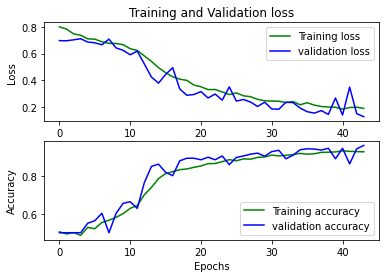

In [123]:
loss_train = history.history['loss']
loss_val   = history.history['val_loss']

acc_train  = history.history['accuracy']
acc_val    = history.history['val_accuracy']

plt.subplot(2,1,1)
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(2,1,2)
plt.plot(acc_train, 'g', label='Training accuracy')
plt.plot(acc_val, 'b', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Save the model 

In [124]:
model.save('karez_cnn_003.h5')

Use the model to predict if Karez tunnels are present or not

Calculate a confusion matrix. 

In [126]:
val_predicts = model.predict(validation_generator)
y_pred = 1*(val_predicts >= 0.5)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['karez', 'no karez']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[359  11]
 [ 18 352]]
Classification Report
              precision    recall  f1-score   support

       karez       0.95      0.97      0.96       370
    no karez       0.97      0.95      0.96       370

    accuracy                           0.96       740
   macro avg       0.96      0.96      0.96       740
weighted avg       0.96      0.96      0.96       740



359 out of 370 true positives are found i.e. Karez present

352 out of 370 true negatives are found i.e Karez not present